# Hierarchical Clustering

## 1. Custom Naive Implementation

In [1]:
import numpy as np
import pandas as pd

In [2]:
# the distance function defined as the euclidian distance between two points
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2) # euclidean distance is the l2 norm, with the default value of the 'ord' as 2

# initialize the distance matrix between all points
def initialize_distance_matrix(points):
    num_points = len(points)
    distance_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            distance = euclidean_distance(points[i], points[j])
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
    return distance_matrix

def naive_hc(points):
    num_points = len(points)
    clusters = [{i} for i in range(num_points)]
    distance_matrix = initialize_distance_matrix(points)
    merge_order = []
    linkage_matrix = []

    cluster_labels = list(range(num_points))
    current_cluster_label = num_points

    while len(clusters) > 1:
        min_distance = np.inf
        clusters_to_merge = (-1, -1)

        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                dist = min(distance_matrix[a][b] for a in clusters[i] for b in clusters[j])
                if dist < min_distance:
                    min_distance = dist
                    clusters_to_merge = (i, j)

        i, j = clusters_to_merge
        new_cluster = clusters[i] | clusters[j]
        clusters.append(new_cluster)

        # track cluster indices for linkage matrix
        new_row = [cluster_labels[i], cluster_labels[j], min_distance, len(new_cluster)]
        linkage_matrix.append(new_row)

        # update cluster labels
        cluster_labels.append(current_cluster_label)
        current_cluster_label += 1

        # remove the merged clusters
        clusters.pop(max(i, j))
        clusters.pop(min(i, j))
        cluster_labels.pop(max(i, j))
        cluster_labels.pop(min(i, j))

    return np.array(linkage_matrix)

#### Applying our hierarchical clustering function to randomly generated data:
In the following, we first demonstrate our function with a set of randomly generated data points. 

In [3]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

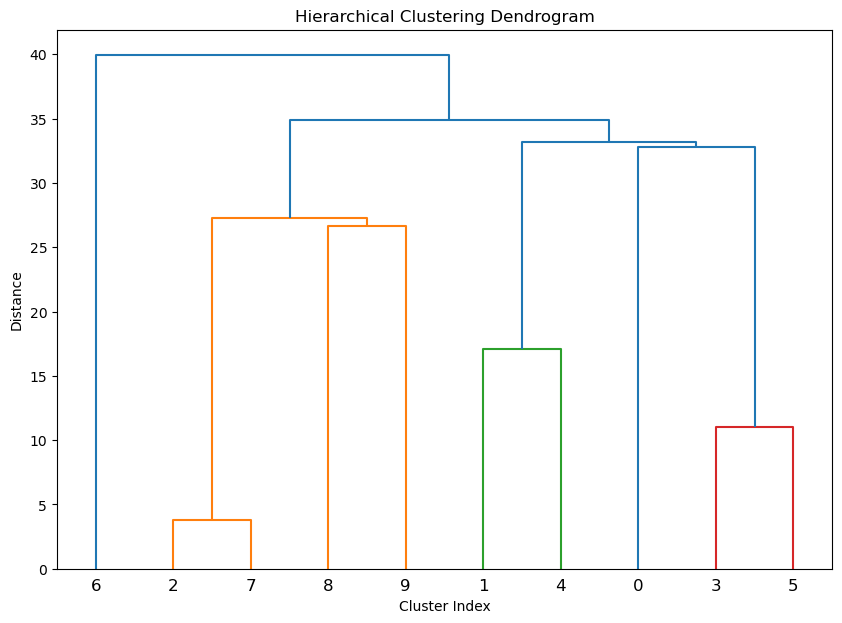

In [4]:
# generate random data points
np.random.seed(42)  # for reproducibility
random_points = np.random.rand(10, 2) * 100  # 10 points in 2D space, scaled by 100

# use the hierarchical clustering function
linkage_matrix = naive_hc(random_points)

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

## 2. Applying to Dataset

### Load and Preprocess Data

In [5]:
raw_df = pd.read_csv('CC_GENERAL.csv') # load dataset
raw_df = raw_df.drop('CUST_ID', axis = 1) # removing the 'Customer ID' label column
raw_df.ffill(inplace=True) # replace the missing values with the last valid (non-null) value
raw_df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [6]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [7]:
# standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(raw_df) 
  
# normalizing the data 
normalized_df = normalize(scaled_df) 
  
# converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

# since we are using a large dataset, 
# we will reduce the dimensions of the data 
pca = PCA(n_components = 2) # reduce to 2 dimensions
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head(2)

,P1,P2
0,-0.489949,-0.679976
1,-0.519099,0.544827


We have:

- Standardized the data using StandardScaler to ensure each feature contributes equally by having a mean of 0 and a standard deviation of 1.
- Normalized the data to ensure the data attributes have the same scale. This can help improve the performance of many machine learning algorithms.
- Performed dimensionality reduction using PCA, reducing the dataset to 2 principal components for simplicity and easier visualization.

In [8]:
# because the naive hierarchical clustering is computationally intensive,
# using a small subset of points for demonstration: 
data_sample = X_principal.sample(n=1000, random_state=1).values
# randomly selects n rows from the DataFrame X_principal, 
# with a set random state, and converted to numpy array

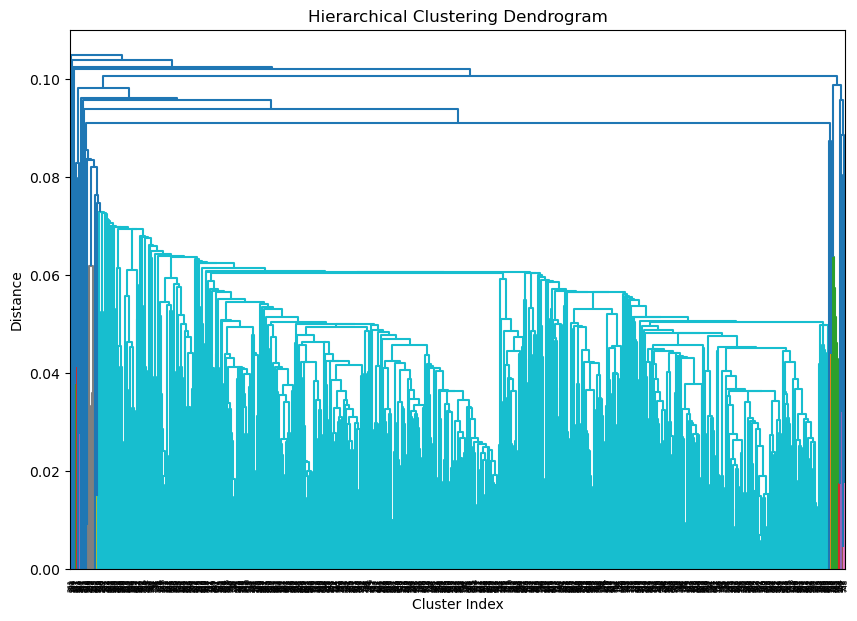

In [9]:
# applying the sample data to our custom hierarchical clustering function
linkage_matrix = naive_hc(data_sample)

# plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

## 3. Built-in Implementation

### Using sklearn.cluster.AgglomerativeClustering for Hierarchical Clustering

In this section, we will be implementing hierarchical clustering by using built-in implementation of hierarchical clustering to compare our results.

In [10]:
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import linkage

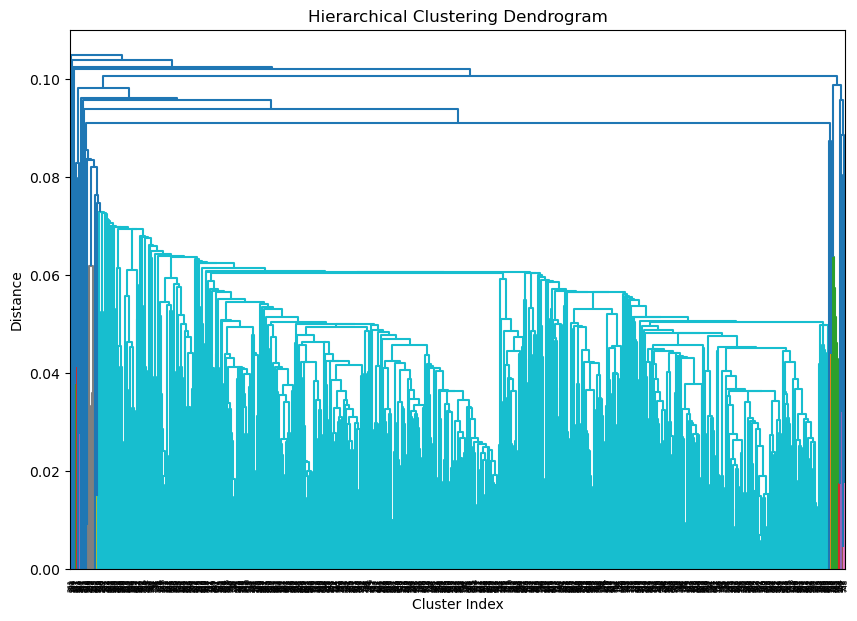

In [11]:
# applying the sample data to the built-in hierarchical clustering function
# using single-linkage
linked = linkage(data_sample, method='single')

# plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

### Comparing Execution Time

In [12]:
import time

def time_function(func, *args):
    start_time = time.time()
    func(*args)
    end_time = time.time()
    return end_time - start_time

In [13]:
# timing our custom hierarchical clustering
custom_clustering_time = time_function(naive_hc, data_sample)

# timing AgglomerativeClustering
sklearn_clustering_time = time_function(AgglomerativeClustering, data_sample) 

print(f"Custom Hierarchical Clustering took: {custom_clustering_time:.2f} seconds")
print(f"Scikit-Learn Agglomerative Clustering took: {sklearn_clustering_time:.2f} seconds")


Custom Hierarchical Clustering took: 200.02 seconds
Scikit-Learn Agglomerative Clustering took: 0.00 seconds


### Resources

- https://www.kaggle.com/code/vipulgandhi/hierarchical-clustering-explanation/notebook
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html